Sources:
    
http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/

http://scikit-learn.org/stable/modules/tree.html

# Day 6: Decision Trees and K Nearest Neighbors

### Things to keep in mind with decision trees:
* They work with discrete values
* They are prone to overfitting

Today we will try to predict a student's GPA using Decision Trees and K Nearest Neighbors Algorithms. Let's start by loading in our data, looking at it and reshaping it to the form that's necessary for our algorithm.

In [1]:
# import libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys, os
from sklearn.metrics import accuracy_score
import sys
sys.path.append('..')
import ff

### Set input variables

In [2]:
# directory with output data
background = "../../ai4all_data/background.csv"
train = "../../ai4all_data/train.csv"
output_dir = "../output"

# if the output directory hasn't been created, Python will complain, so let's create it if it doesn't exist yet.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Data Preprocessing.

### Read in data

In [3]:
data_frame = pd.read_csv(background, low_memory=False)
print(data_frame.shape)
data_frame.head()

(4242, 12943)


,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,1,-3,NaN,-3,40,NaN,0,NaN,NaN,NaN,...,-3.0,-3.000000,-3.000000,-3.000000,-3.0,-3.000000,-3.000000,-3,-3.000000,-3.000000
1,2,-3,NaN,0,40,NaN,1,NaN,NaN,NaN,...,-3.0,8.473318,-3.000000,-3.000000,-3.0,-3.000000,9.845074,-3,-3.000000,9.723551
2,3,-3,NaN,0,35,NaN,1,NaN,NaN,NaN,...,-3.0,-3.000000,9.097495,10.071504,-3.0,-3.000000,-3.000000,-3,-3.000000,-3.000000
3,4,-3,NaN,0,30,NaN,1,NaN,NaN,NaN,...,-3.0,-3.000000,9.512706,10.286578,-3.0,10.677285,-3.000000,-3,8.522331,10.608137
4,5,-3,NaN,0,25,NaN,1,NaN,NaN,NaN,...,-3.0,-3.000000,11.076016,9.615958,-3.0,9.731979,-3.000000,-3,10.115313,9.646466


In [4]:
num_samples = data_frame.shape[0]

# "assert" will throw an error if the condition is not fulfilled. This checks whether the challengeID frame is 
# a set of consecutive numbers from 1 to number of samples+1
assert list(data_frame['challengeID'].to_dict().values()) == list(range(1, num_samples+1))

# move from the original index (starting from 0) to the challengeID index
data_frame = data_frame.set_index('challengeID')

data_frame.head()

,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,cm1natsmx,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-3,NaN,-3,40,NaN,0,NaN,NaN,NaN,NaN,...,-3.0,-3.000000,-3.000000,-3.000000,-3.0,-3.000000,-3.000000,-3,-3.000000,-3.000000
2,-3,NaN,0,40,NaN,1,NaN,NaN,NaN,NaN,...,-3.0,8.473318,-3.000000,-3.000000,-3.0,-3.000000,9.845074,-3,-3.000000,9.723551
3,-3,NaN,0,35,NaN,1,NaN,NaN,NaN,NaN,...,-3.0,-3.000000,9.097495,10.071504,-3.0,-3.000000,-3.000000,-3,-3.000000,-3.000000
4,-3,NaN,0,30,NaN,1,NaN,NaN,NaN,NaN,...,-3.0,-3.000000,9.512706,10.286578,-3.0,10.677285,-3.000000,-3,8.522331,10.608137
5,-3,NaN,0,25,NaN,1,NaN,NaN,NaN,NaN,...,-3.0,-3.000000,11.076016,9.615958,-3.0,9.731979,-3.000000,-3,10.115313,9.646466


Observe that now the challengeID is the index. Also, see that many of the variables have NaN values.

In [5]:
data_frame = data_frame.replace('missing', -3)
data_frame = data_frame.apply(lambda x: pd.to_numeric(x, errors='ignore'))
# removing all non-numeric elements
data_frame = data_frame.select_dtypes(include = [np.number])

In [6]:
# read in the 6 outcome variables
outcome = pd.read_csv(train, low_memory=False)
outcome.head()

,challengeID,gpa,grit,materialHardship,eviction,layoff,jobTraining
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,3,NaN,NaN,NaN,NaN,NaN,NaN
2,6,NaN,3.50,0.090909,0.0,0.0,0.0
3,7,2.5,3.25,0.000000,0.0,0.0,0.0
4,8,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# again, set the challengeID as the index
outcome = outcome.set_index('challengeID')
print(outcome.shape[0])
# remove the rows where GPA is a NaN
outcome = outcome.loc[~outcome['gpa'].isnull()]
# We see that 956/2121 rows were removed
print(outcome.shape[0])

2121
1165


In [8]:
outcome.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
7,2.50,3.25,0.000000,0.0,0.0,0.0
9,2.25,4.00,0.181818,0.0,0.0,0.0
10,3.25,3.25,0.090909,0.0,NaN,0.0
13,2.75,4.00,0.181818,0.0,0.0,1.0
14,3.25,2.75,0.272727,0.0,1.0,0.0


Observe that the challengeID reflects which rows remain in the outcome DataFrame after NaN removal.

In [9]:
# Now, look at the different values of GPA that occur in the table. You can also look at their frequency:
print(outcome.gpa.unique())
print(outcome.gpa.value_counts(dropna=False))

[ 2.5   2.25  3.25  2.75  2.    3.    3.5   4.    3.75  1.25  1.5   1.75
  1.  ]
3.25    170
3.00    157
2.75    147
2.50    134
3.50    128
2.25    114
4.00     78
3.75     73
2.00     62
1.75     56
1.50     34
1.25      7
1.00      5
Name: gpa, dtype: int64


We are interested in predicting GPA. Look at the variables in the data set and write out 5 ideas of the variables you'd expect to be correlated with GPA:

Let's start by studying three variables:
* t5c13a: literacy skills
* t5c13b: social science skills
* t5c13c: math skills

It intuitively makes sense they would be correlated with GPA (it's a little bit of a cheat: other people have already found it for us!).
    
Let's look at the values they contain:

In [10]:
# Let's have a closer look at the data. We have three predictor variables: t5c13a, t5c13b and t5c13c.
print(data_frame.t5c13a.unique())
print(data_frame.t5c13b.unique())
print(data_frame.t5c13c.unique())

# We observe that there are no NaN values, which is great, we won't need to remove them.
# However, if you look at the documentation, you can see that all the negative values actually are different types
# of missingness:
print(ff.select('t5c13a'))

[-9  3  1  4  2 -1  5 -2 -3]
[-9  3  2  4  1 -1  5 -2 -3]
[-9  2  4  3  1 -1  5 -2 -3]
{'responses': {'-7': 'N/A', '3': 'average', '-8': 'Out of range', '-2': "Don't know", '2': 'below average', '-5': 'Not asked', '-1': 'Refuse', '-6': 'Skip', '-4': 'Multiple ans', '4': 'above average', '5': 'far above average', '-3': 'Missing', '1': 'far below average', '-9': 'Not in wave'}, 'data_source': 'questionnaire', 'label': "C13A. Child's language and literacy skills", 'topics': [{'topic': 'cognitive skills', 'umbrella': 'Cognitive and behavioral development'}], 'wave': '5', 'group_id': '3026', 'scope': '20', 'warning': 0, 'group_subid': None, 'leaf': '13a', 'id': 12655, 'data_type': 'oc', 'section': 'c', 'respondent': 't', 'old_name': 't5c13a', 'name': 't5c13a'}


In [11]:
# To see how often a given value occurs, we can use the "value_counts" function
print(data_frame.t5c13a.value_counts())

-9    2228
 3     728
 2     531
 4     441
 1     193
 5     107
-2       7
-1       6
-3       1
Name: t5c13a, dtype: int64


### Pick out the students whose language and literacy skills ('t5c13a'), social science skills ('t5c13b'), math skills ('t5c13c') and GPA are not missing (are above 0)

In [12]:
# Choose only those rows of data_frame that are left in outcome
rows_remaining_outcome = outcome.index.values
rows_to_keep_dataframe = data_frame.index.isin(rows_remaining_outcome)
data_frame = data_frame.loc[rows_to_keep_dataframe]

# subselect the three columns we are interested in
skills_columns = data_frame[['t5c13a', 't5c13b', 't5c13c']]
skills_columns.head()

,t5c13a,t5c13b,t5c13c
challengeID,,,
7,-9,-9,-9
9,1,2,2
10,-9,-9,-9
13,-9,-9,-9
14,3,4,4


In [13]:
# Pick out students whose skills are non-missing (above 0 values)
X = skills_columns[(skills_columns>0).all(1)]
# The .all(1) function says "apply the >0 condition only if all columns (all elements across dimension 1) fulfull it.
# This guarantees that only the rows where all skills have non-missing values will be selected.

In [14]:
X.head()

,t5c13a,t5c13b,t5c13c
challengeID,,,
9,1,2,2
14,3,4,4
16,1,2,2
18,2,2,2
23,2,4,3


In [15]:
# At this point, you may want to save the data frame you just created. You can do it by calling
# my_path = "insert_your_path_X" # edit this
# X.to_csv(my_path)

### Now pick out the corresponding GPA

In [16]:
Y = outcome.loc[outcome.index.isin(X.index.values)]

In [17]:
Y.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
9,2.25,4.00,0.181818,0.0,0.0,0.0
14,3.25,2.75,0.272727,0.0,1.0,0.0
16,2.00,3.50,0.090909,0.0,0.0,1.0
18,2.25,3.00,0.000000,0.0,1.0,0.0
23,2.50,3.25,0.000000,0.0,0.0,0.0


In [18]:
# Ensure that X, Y have the same number of rows:
print(X.shape)
print(Y.shape)

(734, 3)
(734, 6)


In [19]:
# At this point, you may want to save the data frame you just created. You can do it by calling
# my_path = "insert_your_path_Y" # edit this
# Y.to_csv(my_path)

In [20]:
# Let's again have a closer look at the data. We have three predictor variables: t5c13a, t5c13b and t5c13c.
print(X.t5c13a.value_counts())
print(X.t5c13b.value_counts())
print(X.t5c13c.value_counts())
print(Y.gpa.value_counts())

3    281
2    174
4    165
1     76
5     38
Name: t5c13a, dtype: int64
3    397
4    141
2    127
1     48
5     21
Name: t5c13b, dtype: int64
3    314
4    168
2    159
1     64
5     29
Name: t5c13c, dtype: int64
3.25    104
3.00     96
2.75     95
2.50     82
3.50     81
2.25     73
4.00     54
3.75     51
2.00     36
1.75     30
1.50     23
1.25      5
1.00      4
Name: gpa, dtype: int64


In [21]:
print(len(Y.gpa.unique()))

13


We see that all three columns contain 5 unique categories. 

The GPA is also put into 13 unique categories (although it could be a continuous variable, in this case it's been collected as a discrete variable). 

Decision trees need discrete outcomes (since they are used for classification, not regression). We need to change their data type from Float to String (this will treat them as labels, not numbers)

In [43]:
GPA = Y.gpa.astype('str')
GPA.head()

challengeID
9     2.25
14    3.25
16     2.0
18    2.25
23     2.5
Name: gpa, dtype: object

# 2. Decision Trees

In [40]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, GPA, test_size = 0.3, random_state = 100)

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
y_pred = clf.predict(X_test).astype(float)

### Draw the tree graph

In [ ]:
tree.export_graphviz(clf_gini,out_file='tree.dot')
import pydot
# (graph,) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('somefile.png')

In [65]:
# PLOT TREE
from sklearn import tree
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(clf, out_file=None,  feature_names=['literacy','science','math'])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_svg("tree_MaxDepth10.svg")

# convert svg to png
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
drawing = svg2rlg("tree_MaxDepth10.svg")
renderPM.drawToFile(drawing, "file.png")

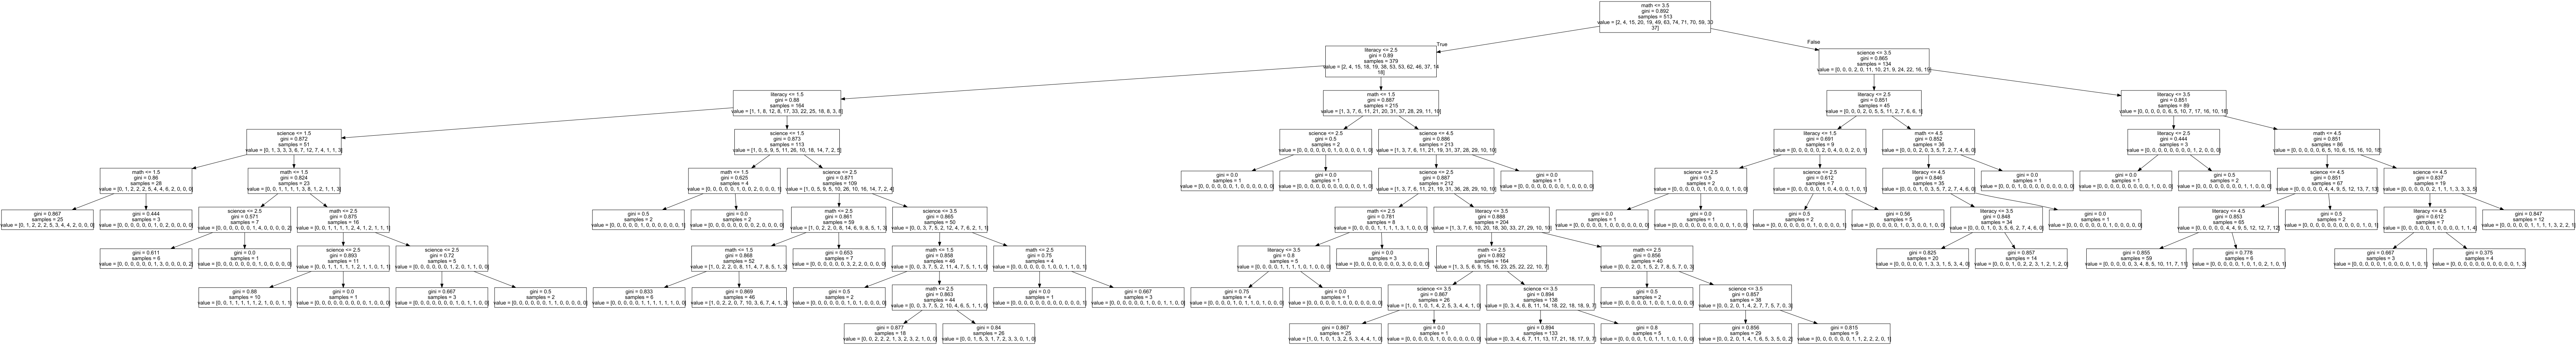

In [66]:
# display saved png file
i = Image(filename='file.png')
i

In [ ]:
pred = clf_gini.predict(X_test)
accuracy = sum(pred==y_test.values)/pred.shape[0]
accuracy

### Find mean squared error of prediction

In [ ]:
sum(pred==y_test.values)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(pred, y_test.values))

# TODO: interpreting created trees

# K-Nearest Neighbors Regression
http://scikit-learn.org/stable/modules/neighbors.html

TODO: add visualization for clustering

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors=20, algorithm='ball_tree').fit(X_train, y_train)
distances, indices = nbrs.kneighbors(X_train)

### Show connections between neighbors

In [ ]:
nbrs.kneighbors_graph(X_train).toarray()

In [ ]:
pred = nbrs.predict(X_test)
accuracy = sum(pred==y_test.values)/pred.shape[0]
accuracy

Exercise: Try changing the n_neighbors variable, see what happens.

In [ ]:
results = np.zeros(28)
for i in range(2,30):
    nbrs = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree').fit(X_train, y_train)
    pred = nbrs.predict(X_test)
    accuracy = sum(pred==y_test.values)/pred.shape[0]
    results[i-2] = accuracy

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(list(range(2,30)),results)
plt.show()